## Data and Package Importing

In [131]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from QC import *
sc.settings.set_figure_params(dpi=100)

### Load data and preprocess

In [132]:
adata = sc.read_h5ad("testing/filtered-3777-S2.h5ad")

In [133]:
adata = reorder_AnnData(adata) #quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
adata #this also calculates the n_counts value, which is the total number of counts per cell/barcode

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter', 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'Total', 'LogProb', 'PValue', 'Limited', 'FDR', 'empty', 'barcode', 'victoria_filter', 'thresh_mean_filter', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [134]:
adata.raw = adata #checkpoint before normalizing and scaling data

In [135]:
#create new "observation" as percent mito and mean mito
mito_genes = adata.var_names.str.startswith('mt-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / adata.obs['n_counts']
adata.obs['mean_mito'] = np.mean(adata[:, mito_genes].X, axis=1)

In [136]:
#create new "observation" as percent hematopoietic and mean hematopoietic
hematopoietic_genes = adata.var_names.str.contains('Hbb-bs$|Cd14$|Jchain$|NAGK$')
adata.obs['percent_hematopoietic'] = np.sum(adata[:, hematopoietic_genes].X, axis=1) / adata.obs['n_counts']
adata.obs['mean_hematopoietic'] = np.mean(adata[:, hematopoietic_genes].X, axis=1)

#It's important to examine multiple methods of compiling genes into a single meta-feature, as percents may be biased towards the number of genes used in the summation while means may be thrown off by outliers.

### Normalize and perform linear dimensionality reduction with PCA

In [137]:
sc.pp.normalize_total(adata) #each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(adata) #log1p normalization

In [138]:
#same as above but wrapped up in one function and utilizes the arcsinh transform instead of log1p, commented out for convenience
#arcsinh_transform(adata)

In [139]:
adata

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter', 'mean_mito', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'Total', 'LogProb', 'PValue', 'Limited', 'FDR', 'empty', 'barcode', 'victoria_filter', 'thresh_mean_filter', 'n_counts', 'percent_mito', 'percent_hematopoietic', 'mean_hematopoietic'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [140]:
sc.pp.scale(adata) #scaling by variance and centering to zero for visualization
sc.tl.pca(adata) #performing PCA

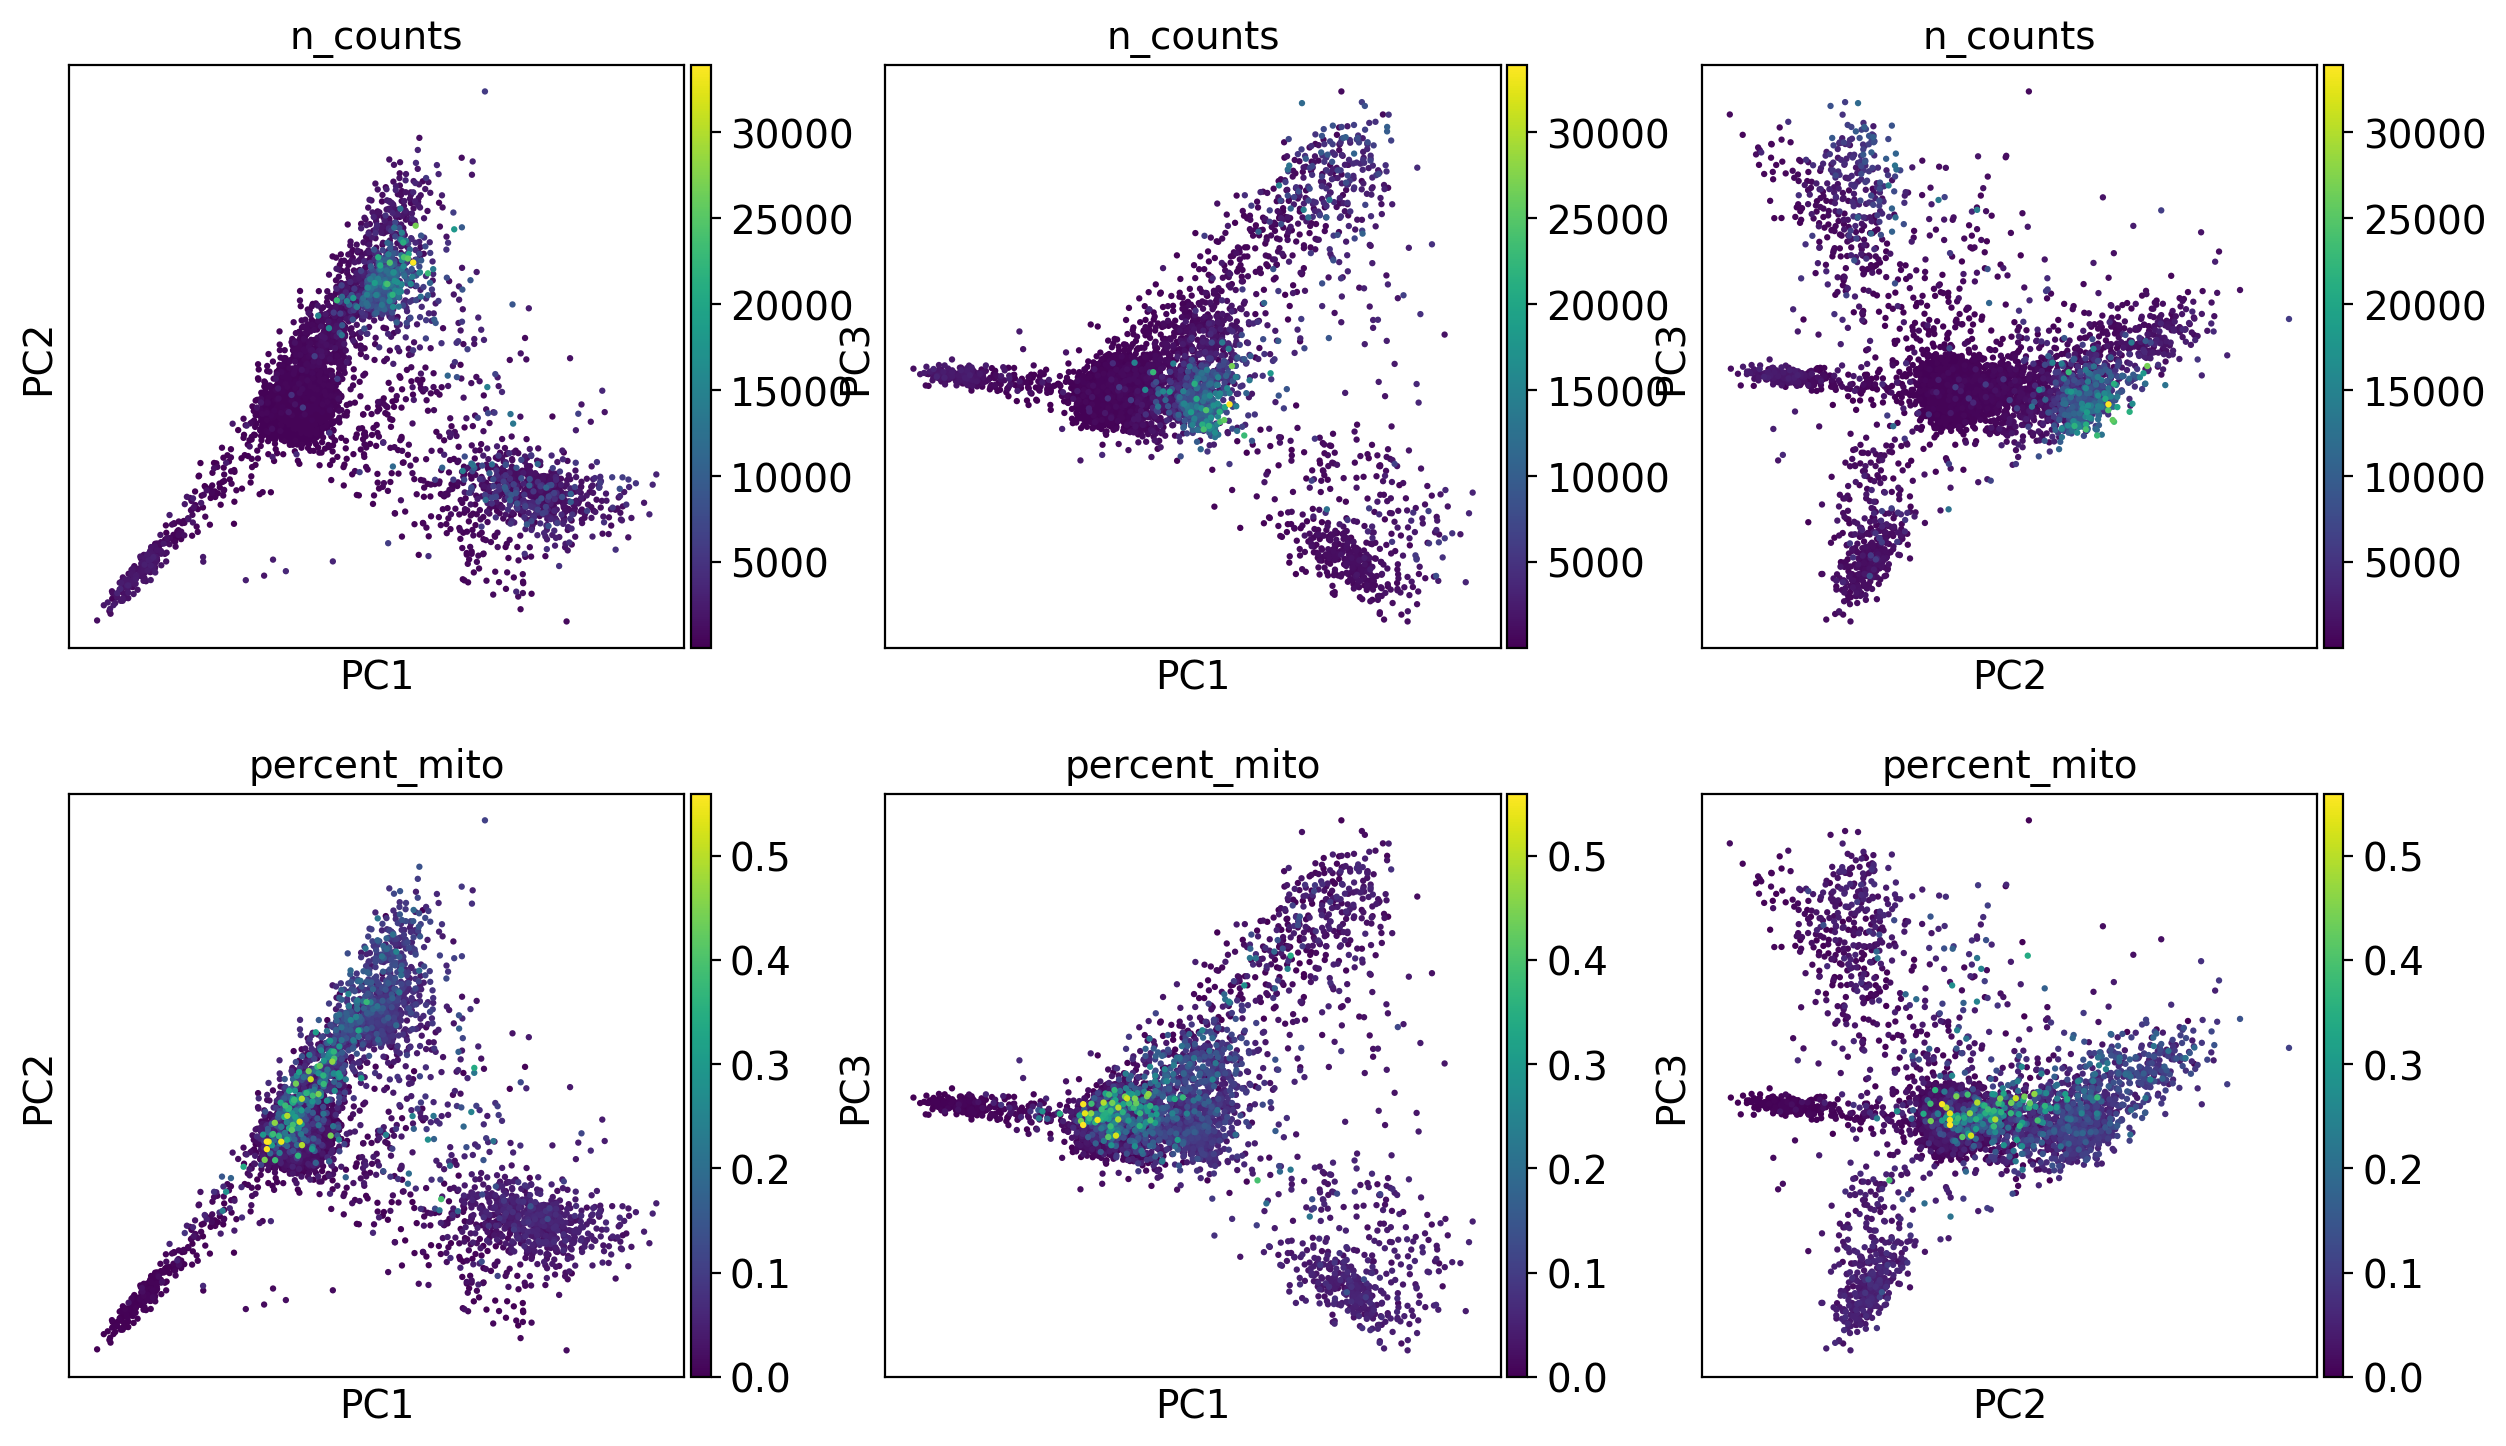

In [141]:
sc.pl.pca(adata, color=['n_counts','percent_mito'],components=['1,2','1,3','2,3'],ncols=3)

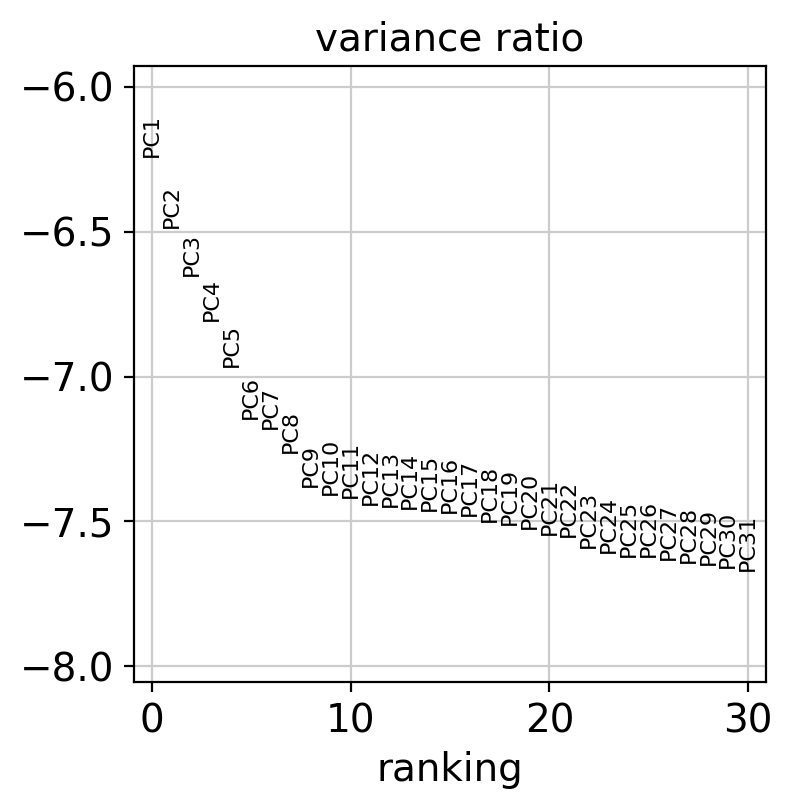

In [142]:
sc.pl.pca_variance_ratio(adata, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [143]:
sc.pp.neighbors(adata,n_neighbors=30, n_pcs=20) #UMAP requires this neighborhood calculation first, will give deprecation warnings

In [144]:
sc.tl.umap(adata) #perform UMAP

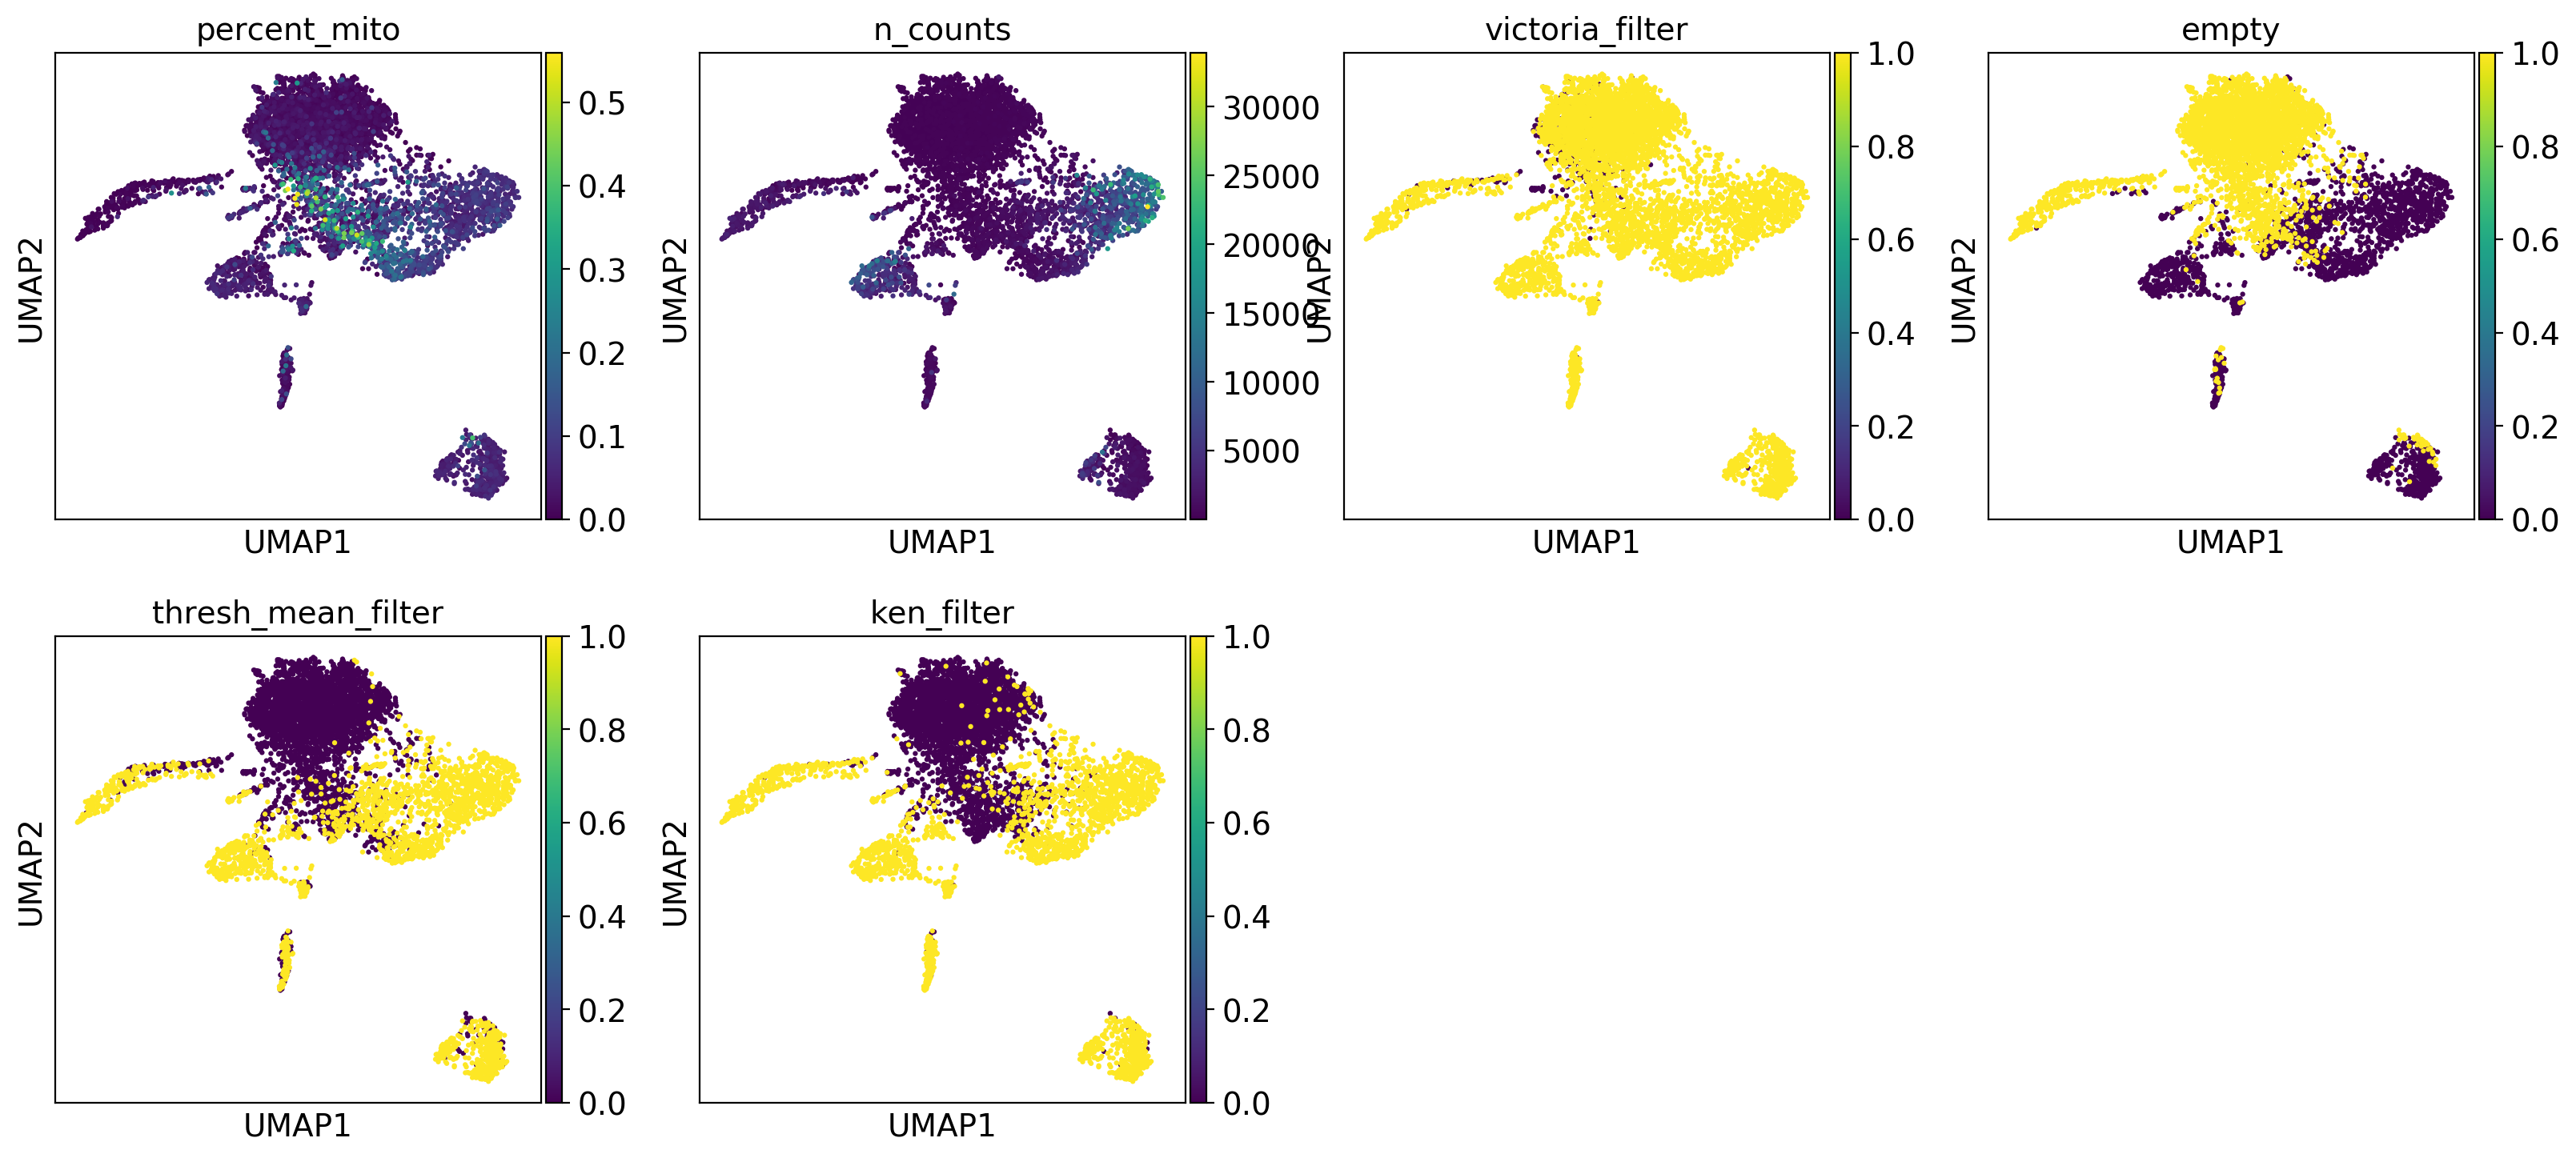

In [145]:
sc.pl.umap(adata,color=['percent_mito','n_counts', 'victoria_filter', 'empty', 'thresh_mean_filter', 'ken_filter']) #plot marker genes to determine which clusters to keep or gate out

In [146]:
adata.obs

ken_filter  mean_mito  n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                      
0               1  66.027023               7182                 8.879472   
1               1  86.945946               6016                 8.702344   
2               1  43.270271               6099                 8.716044   
8               1  45.027027               5938                 8.689296   
3               1  35.324326               5646                 8.638880   
...           ...        ...                ...                      ...   
4579            0   0.027027                 15                 2.772589   
5720            0   0.027027                 11                 2.484907   
5003            0   0.000000                 12                 2.564949   
4586            0   0.000000                 12                 2.564949   
3839            0   0.000000                 10                 2.397895   

       total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
index                                                                 
0           33924.0           10.431908                   20.988091   
1           26851.0           10.198095                   28.881606   
2           25590.0           10.149996                   19.921844   
8           24390.0           10.101970                   21.775318   
3           24030.0           10.087100                   21.223471   
...             ...                 ...                         ...   
4579           15.0            2.772589                  100.000000   
5720           14.0            2.708050                  100.000000   
5003           13.0            2.639057                  100.000000   
4586           12.0            2.564949                  100.000000   
3839           11.0            2.484907                  100.000000   

       pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
index                                                             
0                        28.599222                    37.619385   
1                        35.588991                    43.417377   
2                        27.018367                    36.291520   
8                        28.798688                    37.872079   
3                        28.942988                    38.193924   
...                            ...                          ...   
4579                    100.000000                   100.000000   
5720                    100.000000                   100.000000   
5003                    100.000000                   100.000000   
4586                    100.000000                   100.000000   
3839                    100.000000                   100.000000   

       pct_counts_in_top_500_genes  ...  Limited  FDR  empty  barcode  \
index                               ...                                 
0                        51.173211  ...     True  0.0      0        0   
1                        55.886187  ...     True  0.0      0        1   
2                        50.691676  ...     True  0.0      0        2   
8                        51.779418  ...     True  0.0      0        8   
3                        53.116937  ...     True  0.0      0        3   
...                            ...  ...      ...  ...    ...      ...   
4579                    100.000000  ...      nan  NaN      1     4579   
5720                    100.000000  ...      nan  NaN      1     5720   
5003                    100.000000  ...      nan  NaN      1     5003   
4586                    100.000000  ...      nan  NaN      1     4586   
3839                    100.000000  ...      nan  NaN      1     3839   

       victoria_filter  thresh_mean_filter  n_counts percent_mito  \
index                                                               
0                  1.0                 1.0   33924.0     0.072014   
1                  1.0                 1.0   26851.0     0.119809

### Clustering

In [82]:
sc.tl.louvain(adata,resolution=1.6) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

ModuleNotFoundError: No module named 'louvain'

In [ ]:
sc.pl.umap(adata, color=['louvain'],wspace=0.5,palette='tab20')

### Cluster quantification and non-parametric testing of gene expression profiles for gating

In [ ]:
cluster_summary_stats(adata,raw=False) #in this case it's after normalization, but if you want to find these statistics for the raw counts, set the raw parameter to True

In [ ]:
cluster_wilcoxon_rank_sum(adata,['Krt20','Muc2','Jchain','percent_mito','mean_mito','percent_hematopoietic','mean_hematopoietic'],alternative='greater') 
#this takes a list of features that exist in the normalized representation of the data and performs a wilcoxon rank sum test between each cluster against the global counterparts of those data.
#these features can be single genes or compiled 'metagenes' such as the percent_mito and the mean_mito, as long as their values can be accessed in the AnnData object by using the .obs_vector method
#the "alternative" parameter is passed to scipy's "mann-whitney u" to desgnate the sidedness of the test, in this case the default is a one-sided hypothesis for values greater than the null.

In [ ]:
cluster_p_threshold(adata,0.05)
#this takes the p-values calculated above (per cluster) and simply returns a binarized output (0 or 1) that can be visualized
#the output represents wether or not the cluster has a p-value below the set threshold (0.05 in this case) 

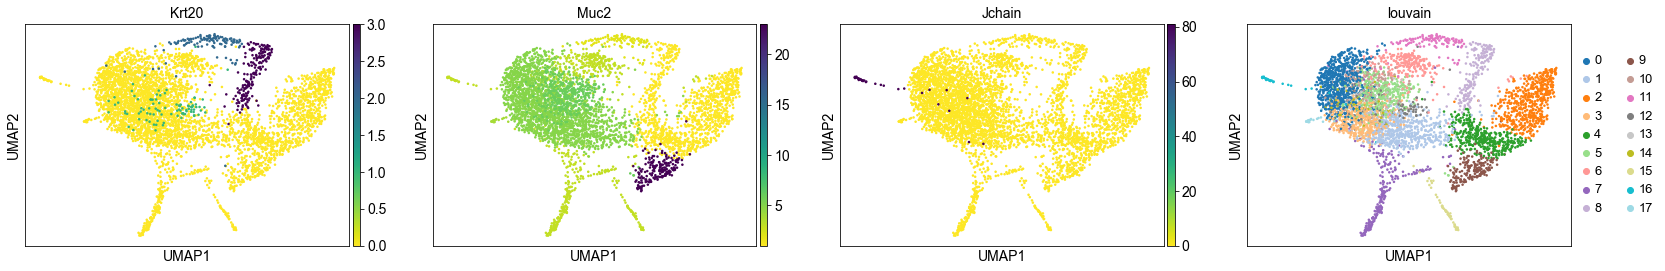

In [28]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Medians') #Cluster medians per feature

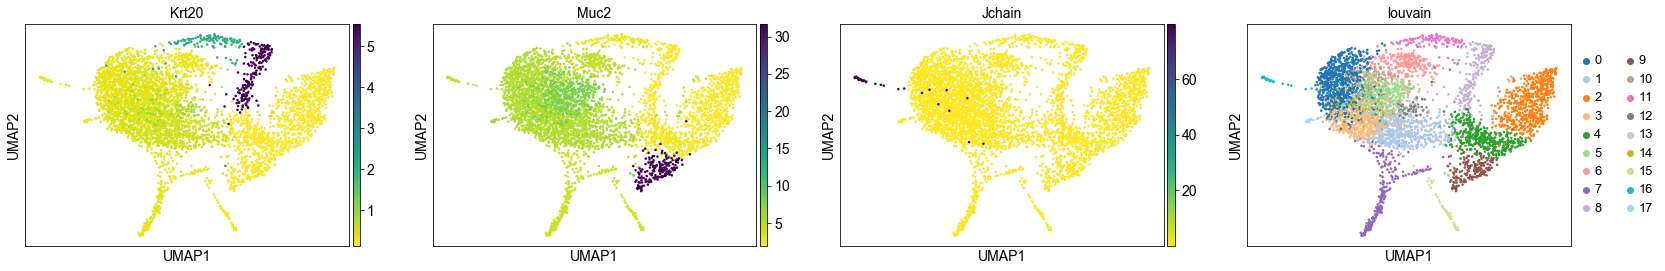

In [29]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Means') #Cluster means per feature≤

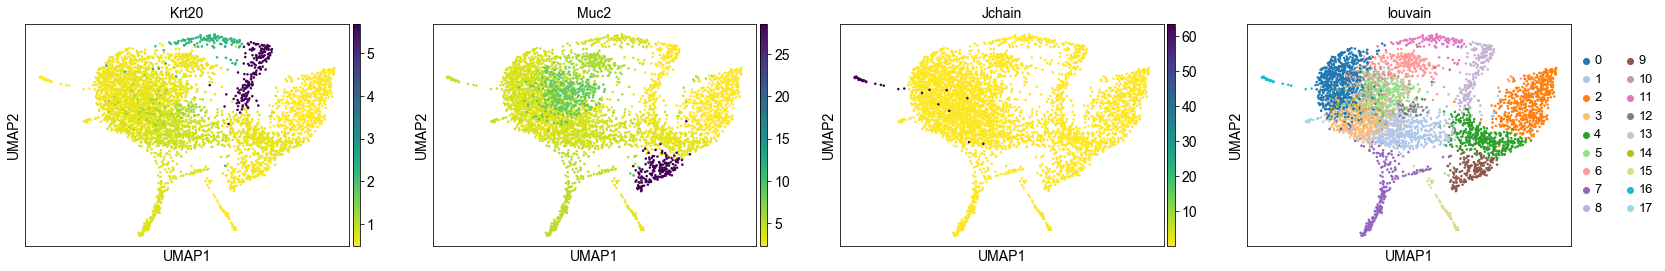

In [30]:
sc.pl.umap(adata,color=['Krt20','Muc2','Jchain','louvain'],color_map='viridis_r',layer='Cluster_Stdevs') #Cluster stdevs per feature

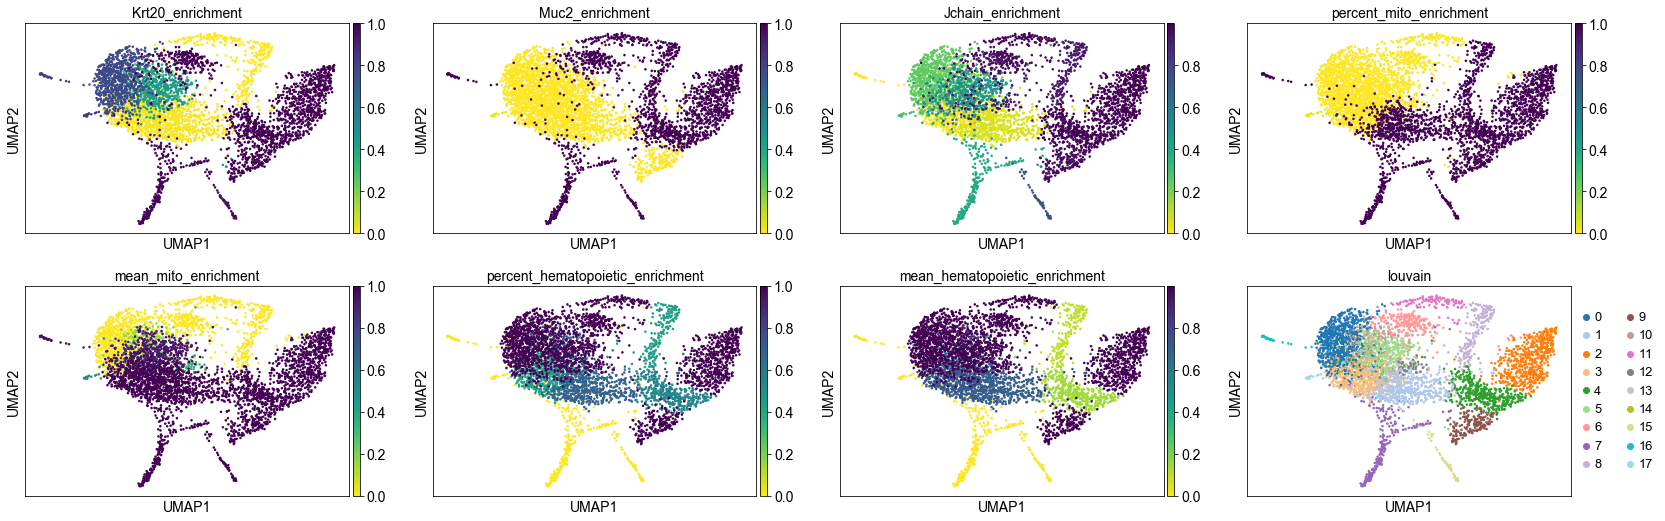

In [31]:
sc.pl.umap(adata,color=['Krt20_enrichment','Muc2_enrichment','Jchain_enrichment',
                        'percent_mito_enrichment','mean_mito_enrichment','percent_hematopoietic_enrichment','mean_hematopoietic_enrichment','louvain'],color_map='viridis_r')
#these are simply the p-values resulting from the features/featuresets tested, this visualization just shows a continuum of p-values per cluster given that test

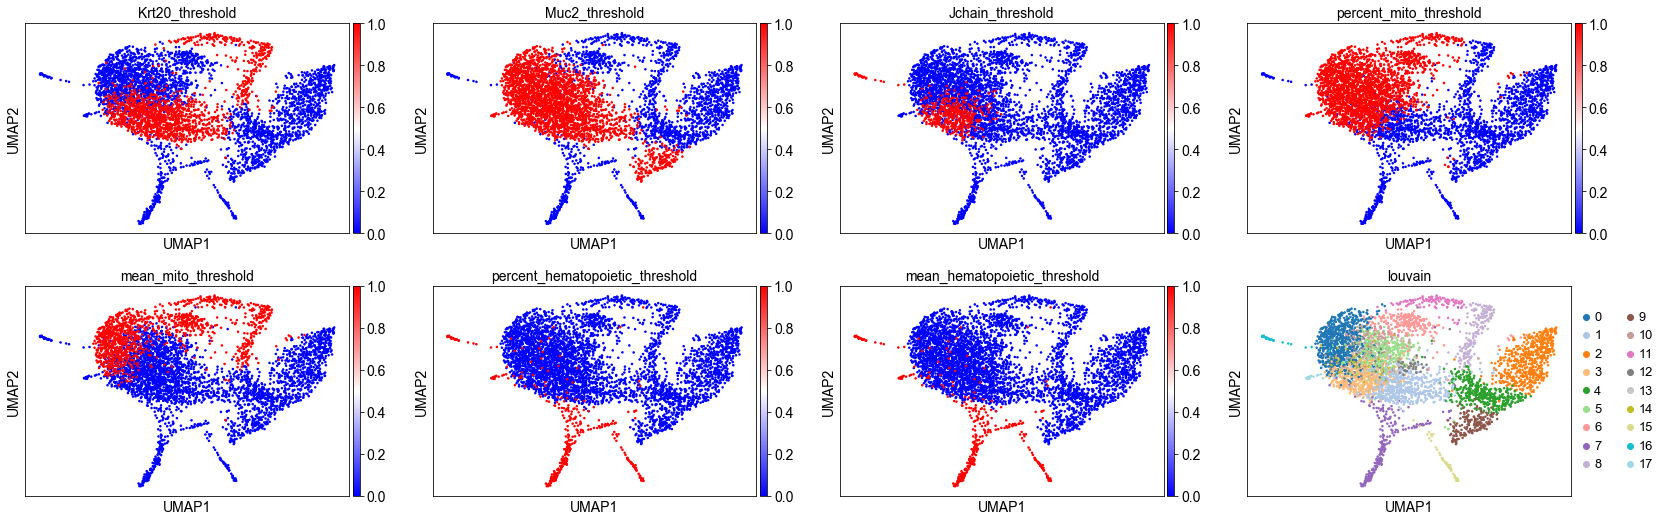

In [32]:
sc.pl.umap(adata,color=['Krt20_threshold','Muc2_threshold','Jchain_threshold',
                        'percent_mito_threshold','mean_mito_threshold','percent_hematopoietic_threshold','mean_hematopoietic_threshold','louvain'],color_map = 'bwr')
#similar to above, but with significance threholded at 0.05 as per the example, this gives us a better idea of which louvain clusters to gate out based off of statistical bases

In [34]:
#the above overlays are simply to guide the louvain cluster gating process by providing more quantitative and statistically robust methods for determining which clusters to gate out  

In [35]:
to_keep = np.where(adata.obs['louvain'].isin(['2','4','7','8']))[0] #fill in the indices of the clusters you want to keep here
#we choose these to keep because all other clusters have a significant enrichment for mitochondrial genes or hematopoetic cells

In [58]:
adata_filtered = sc.AnnData(adata.raw.X[to_keep,:]) #subsetting the original data to make a filtered dataset, here, we subset the raw (.raw) count data for our new object/QC'd dataset
adata_filtered.obs = pd.DataFrame(adata.obs.iloc[to_keep,:]['n_counts']) #subsetting the original data to make a filtered dataset
adata_filtered.var = adata.var #transferring variable/feature names 

In [59]:
adata_filtered #quick check of reduced/filtered dataset properties
#note that this example does NOT transfer over the calculated observations (though possible), this is simply to simplify the object for downstream analysis, a "fresh start" in a way
#this object simply contains a subset of cells and their gene counts given the starting dataset with no further calculated features outside of n_counts

AnnData object with n_obs × n_vars = 1396 × 80009 
    obs: 'n_counts'

In [61]:
adata_filtered.write_h5ad("s1_filtered.h5ad",compression='gzip') #optional saving results to file as compressed .h5ad 